<a href="https://colab.research.google.com/github/dvelle/0x-launch-kit/blob/master/Copy_of_AibbeyRoadV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## General Imports

In [ ]:
import datetime, os

# Dataset Set up

## Dataset Download

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import time
import re


# Define save directory.
save_dir = '/content/dataset/guitar/'

guitarurl = 'https://www.ibiblio.org/mutopia/cgibin/make-table.cgi?Instrument=Guitar'

dowurl = 'https://www.ibiblio.org/mutopia'

print(requests.get(guitarurl))

web_page = bs(requests.get(guitarurl, {}).text, "lxml")

In [ ]:
web_page

In [ ]:
links = web_page.find_all("a")
links

In [ ]:
def downloadFile(link, filename):
    mid_file = requests.get(link, stream=True)
    with open(filename, 'wb') as saveMidFile:
        saveMidFile.write(mid_file.content)
        print('Downloaded {} successfully.'.format(filename))

In [ ]:
for link in links:
        href = link['href']
        if href.find('.mid') >= 0:
            href = href[2:]
            print(dowurl + href)
            dowlink = dowurl + href
            #urlretrieve(dowlink, save_dir+href)

            #r = requests.get(dowurl, stream=True)

            #print(href.rsplit('/',2)[1:][1])
            filename = href.rsplit('/',2)[1:][1]

            #print(save_dir+filename)

            #open(save_dir+filename, 'wb').write(r.content)

            #urlretrieve(dowurl, save_dir+filename)
            downloadFile(dowlink, save_dir+filename)
            
            time.sleep(4.0)

In [ ]:
#Download Guitar Dataset

!zip -r /content/file.zip /content/dataset/guitar

from google.colab import files
files.download("/content/file.zip")

## Sample Audio file load

(for both models)

In [ ]:
# Define data directory
data_dir = '/content/audio/'

sample_file = data_dir+'WhereIsMyMind.mid'

# **Music Generator by Datacamp (non-bedrock)**



*   Does not work





## Set-up (DataCamp)

In [ ]:
!pip install music21
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir generated
!mkdir audio
!mkdir dataset
!mkdir dataset/guitar

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import numpy as np
import tensorflow as tf
from music21 import converter


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


## Music Representation

In [ ]:
# Define data directory
data_dir = '/content/audio/'

sample_file = data_dir+'coolio.mid'

# Parse MIDI file and convert notes to chords
score = converter.parse(data_dir+'coolio.mid').chordify()

# Display as sheet music
#print(score.show())

In [ ]:
print(score.elements[10])

<music21.chord.Chord G#1 C#2 E-3 F#3 G#3 A4 C5>


## Data Collection and Preparation

In [ ]:
from music21 import converter, pitch, interval

# Define save directory
save_dir = '/content/dataset/guitar/'

# Identify list of MIDI files
songList = os.listdir(save_dir)

# Create empty list for scores
originalScores = []

# Load and make list of stream objects
for song in songList:
    score = converter.parse(save_dir+song)
    originalScores.append(score)

Data Dimensionality Reduction (prototype only)

In [ ]:
# Identify list of MIDI files
songList = os.listdir(save_dir)
songList = [song for song in songList if song.lower().find('giuliani')>-1]# Identify list of MIDI files
songList = os.listdir(save_dir)
songList = [song for song in songList if song.lower().find('giuliani')>-1]

In [ ]:
from music21 import instrument

# Define function to test whether stream is monotonic
def monophonic(stream):
    try:
        length = len(instrument.partitionByInstrument(stream).parts)
    except:
        length = 0
    return length == 1

# Merge notes into chords
originalScores = [song.chordify() for song in originalScores]

In [ ]:
from music21 import note, chord

# Define empty lists of lists
originalChords = [[] for _ in originalScores]
originalDurations = [[] for _ in originalScores]
originalKeys = []

# Extract notes, chords, durations, and keys
for i, song in enumerate(originalScores):
    originalKeys.append(str(song.analyze('key')))
    for element in song:
        if isinstance(element, note.Note):
            originalChords[i].append(element.pitch)
            originalDurations[i].append(element.duration.quarterLength)
        elif isinstance(element, chord.Chord):
            originalChords[i].append('.'.join(str(n) for n in element.pitches))
            originalDurations[i].append(element.duration.quarterLength)
    print(str(i))

In [ ]:
# Create list of chords and durations from songs in C major
cMajorChords = [c for (c, k) in zip(originalChords, originalKeys) if (k == 'C major')]
cMajorDurations = [c for (c, k) in zip(originalDurations, originalKeys) if (k == 'C major')]

In [ ]:
# Map unique chords to integers
uniqueChords = np.unique([i for s in originalChords for i in s])
chordToInt = dict(zip(uniqueChords, list(range(0, len(uniqueChords)))))

# Map unique durations to integers
uniqueDurations = np.unique([i for s in originalDurations for i in s])
durationToInt = dict(zip(uniqueDurations, list(range(0, len(uniqueDurations)))))

# Print number of unique notes and chords
print(len(uniqueChords))

# Print number of unique durations
print(len(uniqueDurations))

3681
24


In [ ]:
# Invert chord and duration dictionaries
intToChord = {i: c for c, i in chordToInt.items()}
intToDuration = {i: c for c, i in durationToInt.items()}

In [ ]:
# Define sequence length
sequenceLength = 12

# Define empty arrays for train data
trainChords = []
trainDurations = []

# Construct training sequences for chords and durations
for s in range(len(cMajorChords)):
    chordList = [chordToInt[c] for c in cMajorChords[s]]
    durationList = [durationToInt[d] for d in cMajorDurations[s]]
    for i in range(len(chordList) - sequenceLength):
        trainChords.append(chordList[i:i+sequenceLength])
        trainDurations.append(durationList[i:i+sequenceLength])

In [ ]:
type(trainChords)

list

## Music Generation Model Training 



In this section, we'll make use of the dataset we assembled and prepared to generate music. We'll consider three different models of music generation, starting with the simplest:


1.   The Autoencoder
2.   The Variational Autoencoder (VAE).
3.   The Long Short-Term Memory Model (LSTM)


In [ ]:
# Convert to one-hot encoding and swap chord and sequence dimensions
trainChords = tf.keras.utils.to_categorical(trainChords).transpose(0,2,1)

# Convert data to numpy array of type float
trainChords = np.array(trainChords, float)

# Define number of samples, chords and notes, and input dimension
nSamples = trainChords.shape[0]
nChords = trainChords.shape[1]
inputDim = nChords * sequenceLength

# Set number of latent features
latentDim = 2

# Set the input dimension
inputDim = nChords * sequenceLength

# Set the embedding layer dimension
embedDim = 64

#nChordsSequence = 

# Flatten sequence of chords into single dimension
trainChordsFlat = trainChords.reshape(nSamples, inputDim)

In [ ]:
# Define number of samples, chords and notes, and input dimension
nSamples = trainChords.shape[0]
nChords = trainChords.shape[1]
inputDim = nChords * sequenceLength

# Set number of latent features
latentDim = 2

In [ ]:
# Define encoder input shape
encoderInput = tf.keras.layers.Input(shape = (inputDim))

# Define decoder input shape
latent = tf.keras.layers.Input(shape = (latentDim))

# Define dense encoding layer connecting input to latent vector
encoded = tf.keras.layers.Dense(latentDim, activation = 'tanh')(encoderInput)

# Define dense decoding layer connecting latent vector to output
decoded = tf.keras.layers.Dense(inputDim, activation = 'sigmoid')(latent)

# Define the encoder and decoder models
encoder = tf.keras.Model(encoderInput, encoded)
decoder = tf.keras.Model(latent, decoded)

# Define autoencoder model
autoencoder = tf.keras.Model(encoderInput, decoder(encoded))

**Autoencoder Training**

In [ ]:
# Compile autoencoder model
autoencoder.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tf.debugging.experimental.enable_dump_debug_info(logdir, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)



# Train autoencoder
autoencoder.fit(trainChordsFlat, trainChordsFlat, epochs = 10,callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs

In [ ]:
# Generate chords from randomly generated latent vector
generatedChords = decoder(np.random.normal(size=(1,latentDim))).numpy().reshape(nChords, sequenceLength).argmax(0)

In [ ]:
# Identify chord sequence from integer sequence
chordSequence = [intToChord[c] for c in generatedChords]

In [ ]:
from music21 import stream

# Set location to save generated music
generated_dir = '/content/generated/'

# Generate stream with guitar as instrument

generatedStream = stream.Stream()
generatedStream.append(instrument.Guitar())

# Append notes and chords to stream object
for j in range(len(chordSequence)):
    try:
        generatedStream.append(note.Note(chordSequence[j].replace('.', ' ')))
    except:
        generatedStream.append(chord.Chord(chordSequence[j].replace('.', ' ')))

generatedStream.write('midi', fp=generated_dir+'autoencoder.mid')

In [ ]:
# Delete guitar folder 

import shutil

shutil.rmtree('/content/dataset/guitar')

# **Music Generator II** 
- Working
- Low Quality
- Outputs things

## Set-up (music-generation.ipynb)

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Process a MIDI file

In [ ]:
print(sample_file)

/content/audio/Bach_Prelude_BWV999.mid


In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Guitar (nylon)


## Extract Notes

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=74, note_name=D5, duration=0.1250
1: pitch=77, note_name=F5, duration=0.1250
2: pitch=62, note_name=D4, duration=0.5000
3: pitch=81, note_name=A5, duration=0.1250
4: pitch=77, note_name=F5, duration=0.1250
5: pitch=74, note_name=D5, duration=0.1250
6: pitch=77, note_name=F5, duration=0.1250
7: pitch=74, note_name=D5, duration=0.1250
8: pitch=69, note_name=A4, duration=0.2500
9: pitch=74, note_name=D5, duration=0.1250


In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch  start    end   step  duration
0     62  0.000  0.500  0.000     0.500
1     74  0.125  0.250  0.125     0.125
2     77  0.250  0.375  0.125     0.125
3     81  0.375  0.500  0.125     0.125
4     77  0.500  0.625  0.125     0.125

In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D4', 'D5', 'F5', 'A5', 'F5', 'D5', 'F5', 'D5', 'A4', 'D5'],
      dtype='<U3')

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [ ]:
plot_piano_roll(raw_notes, count=100)

In [ ]:
plot_piano_roll(raw_notes)

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

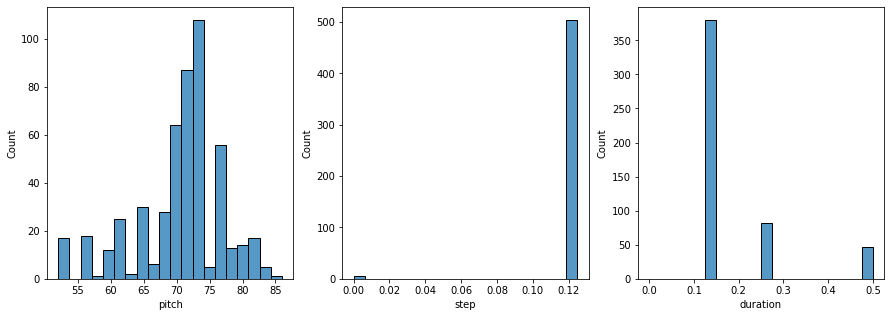

In [ ]:
plot_distributions(raw_notes)

## Create MIDI File

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [ ]:
display_audio(example_pm)

## Create training dataset

In [ ]:
# Define save directory
save_dir = '/content/dataset/guitar/'

# Identify list of MIDI files
songList = os.listdir(save_dir)

In [ ]:
num_files = 50
all_notes = []
for f in songList[:num_files]:
  notes = midi_to_notes(save_dir+f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 20466


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.3515625 0.        1.5      ]
 [0.4453125 0.25      0.125    ]
 [0.4609375 0.125     0.125    ]
 [0.46875   0.125     0.25     ]
 [0.5       0.25      0.25     ]
 [0.53125   0.25      0.25     ]
 [0.5390625 0.25      0.25     ]
 [0.4296875 0.25      0.5      ]
 [0.5390625 0.25      0.25     ]
 [0.4140625 0.25      1.5      ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=48.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.25>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.5>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and Train Model (RNN)

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 128)          67584       ['input_4[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_3[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_3[0][0]']                 
                                                                                            

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

319/319 [==============================] - 7s 18ms/step - loss: 0.9502 - duration_loss: 0.6522 - pitch_loss: 4.8345 - step_loss: 0.0563


{'loss': 0.9501985907554626,
 'duration_loss': 0.6521589756011963,
 'pitch_loss': 4.83447790145874,
 'step_loss': 0.05631595104932785}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

319/319 [==============================] - 8s 21ms/step - loss: 0.9502 - duration_loss: 0.6522 - pitch_loss: 4.8345 - step_loss: 0.0563


{'loss': 0.9501985907554626,
 'duration_loss': 0.6521589756011963,
 'pitch_loss': 4.83447790145874,
 'step_loss': 0.05631595104932785}

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
319/319 [==============================] - 16s 45ms/step - loss: 0.3091 - duration_loss: 0.0881 - pitch_loss: 3.5330 - step_loss: 0.0444
Epoch 2/50
319/319 [==============================] - 13s 41ms/step - loss: 0.2910 - duration_loss: 0.0823 - pitch_loss: 3.3576 - step_loss: 0.0408
Epoch 3/50
319/319 [==============================] - 13s 41ms/step - loss: 0.2861 - duration_loss: 0.0804 - pitch_loss: 3.3253 - step_loss: 0.0395
Epoch 4/50
319/319 [==============================] - 13s 40ms/step - loss: 0.2778 - duration_loss: 0.0778 - pitch_loss: 3.2590 - step_loss: 0.0371
Epoch 5/50
319/319 [==============================] - 13s 40ms/step - loss: 0.2706 - duration_loss: 0.0746 - pitch_loss: 3.2020 - step_loss: 0.0359
Epoch 6/50
319/319 [==============================] - 13s 40ms/step - loss: 0.2638 - duration_loss: 0.0722 - pitch_loss: 3.1358 - step_loss: 0.0348
Epoch 7/50
319/319 [==============================] - 13s 40ms/step - loss: 0.2598 - duration_loss: 0.0703 - pit

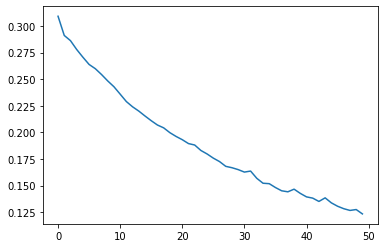

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate Notes

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(10)

pitch      step  duration     start       end
0     67  0.144288  0.227967  0.144288  0.372255
1     78  0.234308  0.346093  0.378595  0.724689
2     78  0.174092  1.072037  0.552687  1.624724
3     78  0.176211  0.980711  0.728898  1.709609
4     78  0.176853  0.911976  0.905751  1.817727
5     78  0.184601  0.929972  1.090352  2.020324
6     78  0.196308  0.978660  1.286660  2.265320
7     78  0.193257  0.990677  1.479917  2.470593
8     79  0.196730  1.018361  1.676646  2.695008
9     78  0.199438  0.990194  1.876084  2.866279

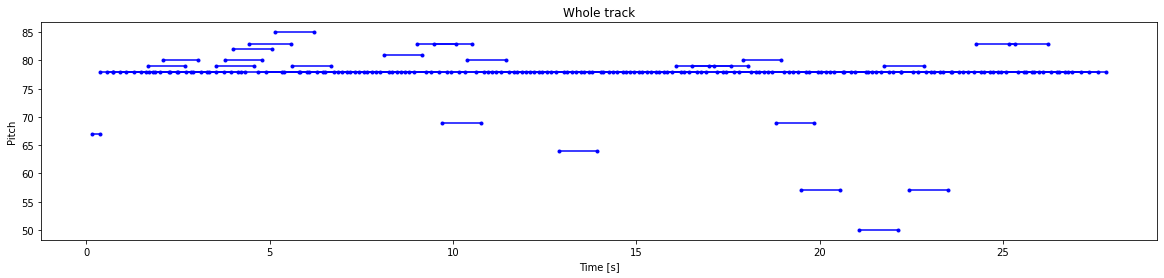

In [ ]:
plot_piano_roll(generated_notes)

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```

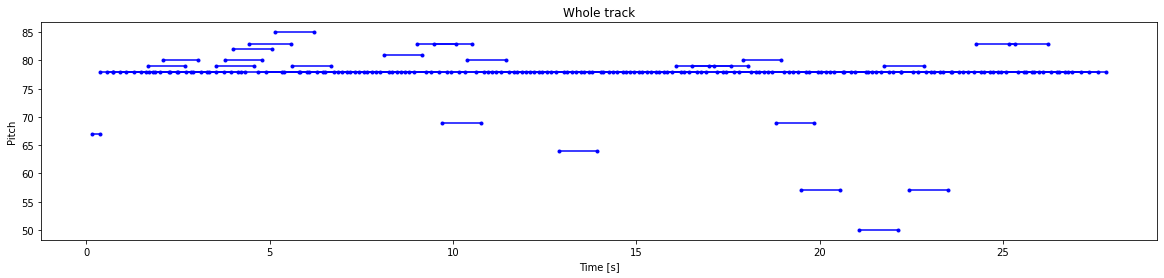

In [ ]:
plot_piano_roll(generated_notes)

In [ ]:
plot_distributions(generated_notes)

# Magenta Transformer Attention RNN

*   Working
*   High Quality Output



If you are using this part of the colab, you must restart the runtime environment

# Step 0: First things first

In [ ]:
#@test {"output": "ignore"}
print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi

!pip install -qU magenta

# Hack to allow python to pick up the newly-installed fluidsynth lib. 
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

print('Importing libraries and defining some helper functions...')
from google.colab import files

import magenta
import note_seq
import tensorflow

print('🎉 Done!')
print(magenta.__version__)
print(tensorflow.__version__)

Installing dependencies...
Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 123934 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
     |████████████████████████████████| 5.6 MB 6.7 MB/s 
     |████████████████████████████████| 51 kB 6.2 MB/s 
     |████████████████████████████████| 1.4 MB 7.7 MB/s 
     |████████████████████████████████| 210 kB 46.2 MB/s 
     |████████████████████████████████| 69 kB 5.0 MB/s 
     |████████████████████████████████| 3.4 MB 42.1 MB/s 
     |████████████████████████████████| 11.2 MB 37.5 MB/s 
     |██████████████

/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB thr

🎉 Done!
2.1.4
2.9.1


## Step 1: Making sounds with NoteSequences

In [ ]:
from note_seq.protobuf import music_pb2

twinkle_twinkle = music_pb2.NoteSequence()

# Add the notes to the sequence.
twinkle_twinkle.notes.add(pitch=60, start_time=0.0, end_time=0.5, velocity=80)
twinkle_twinkle.notes.add(pitch=60, start_time=0.5, end_time=1.0, velocity=80)
twinkle_twinkle.notes.add(pitch=67, start_time=1.0, end_time=1.5, velocity=80)
twinkle_twinkle.notes.add(pitch=67, start_time=1.5, end_time=2.0, velocity=80)
twinkle_twinkle.notes.add(pitch=69, start_time=2.0, end_time=2.5, velocity=80)
twinkle_twinkle.notes.add(pitch=69, start_time=2.5, end_time=3.0, velocity=80)
twinkle_twinkle.notes.add(pitch=67, start_time=3.0, end_time=4.0, velocity=80)
twinkle_twinkle.notes.add(pitch=65, start_time=4.0, end_time=4.5, velocity=80)
twinkle_twinkle.notes.add(pitch=65, start_time=4.5, end_time=5.0, velocity=80)
twinkle_twinkle.notes.add(pitch=64, start_time=5.0, end_time=5.5, velocity=80)
twinkle_twinkle.notes.add(pitch=64, start_time=5.5, end_time=6.0, velocity=80)
twinkle_twinkle.notes.add(pitch=62, start_time=6.0, end_time=6.5, velocity=80)
twinkle_twinkle.notes.add(pitch=62, start_time=6.5, end_time=7.0, velocity=80)
twinkle_twinkle.notes.add(pitch=60, start_time=7.0, end_time=8.0, velocity=80) 
twinkle_twinkle.total_time = 8

twinkle_twinkle.tempos.add(qpm=60);

# This is a colab utility method that visualizes a NoteSequence.
note_seq.plot_sequence(twinkle_twinkle)

# This is a colab utility method that plays a NoteSequence.
note_seq.play_sequence(twinkle_twinkle,synth=note_seq.fluidsynth)

# Here's another NoteSequence!
teapot = music_pb2.NoteSequence()
teapot.notes.add(pitch=69, start_time=0, end_time=0.5, velocity=80)
teapot.notes.add(pitch=71, start_time=0.5, end_time=1, velocity=80)
teapot.notes.add(pitch=73, start_time=1, end_time=1.5, velocity=80)
teapot.notes.add(pitch=74, start_time=1.5, end_time=2, velocity=80)
teapot.notes.add(pitch=76, start_time=2, end_time=2.5, velocity=80)
teapot.notes.add(pitch=81, start_time=3, end_time=4, velocity=80)
teapot.notes.add(pitch=78, start_time=4, end_time=5, velocity=80)
teapot.notes.add(pitch=81, start_time=5, end_time=6, velocity=80)
teapot.notes.add(pitch=76, start_time=6, end_time=8, velocity=80)
teapot.total_time = 8

teapot.tempos.add(qpm=60);

note_seq.plot_sequence(teapot)
note_seq.play_sequence(teapot,synth=note_seq.synthesize)

In [ ]:
drums = music_pb2.NoteSequence()

drums.notes.add(pitch=36, start_time=0, end_time=0.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=38, start_time=0, end_time=0.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=0, end_time=0.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=46, start_time=0, end_time=0.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=0.25, end_time=0.375, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=0.375, end_time=0.5, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=0.5, end_time=0.625, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=50, start_time=0.5, end_time=0.625, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=36, start_time=0.75, end_time=0.875, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=38, start_time=0.75, end_time=0.875, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=0.75, end_time=0.875, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=45, start_time=0.75, end_time=0.875, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=36, start_time=1, end_time=1.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=1, end_time=1.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=46, start_time=1, end_time=1.125, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=42, start_time=1.25, end_time=1.375, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=48, start_time=1.25, end_time=1.375, is_drum=True, instrument=10, velocity=80)
drums.notes.add(pitch=50, start_time=1.25, end_time=1.375, is_drum=True, instrument=10, velocity=80)
drums.total_time = 1.375

drums.tempos.add(qpm=60)

# This is a colab utility method that visualizes a NoteSequence.
note_seq.plot_sequence(drums)

# This is a colab utility method that plays a NoteSequence.
note_seq.play_sequence(drums,synth=note_seq.fluidsynth)

### Converting a NoteSequence to MIDI

In [ ]:
# This creates a file called `drums_sample_output.mid`, containing the drums solo we've been using.
note_seq.sequence_proto_to_midi_file(drums, 'drums_sample_output.mid')

# This is a colab utility method to download that file. In your Python script, you 
# would just write it to disk.
files.download('drums_sample_output.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading MIDI

In [ ]:
sample_seq = note_seq.midi_io.midi_file_to_note_sequence('/content/MrBlueSky.mid')
print(type(sample_seq))

# This is a colab utility method that visualizes a NoteSequence.
note_seq.plot_sequence(sample_seq)

# This is a colab utility method that plays a NoteSequence.
note_seq.play_sequence(sample_seq,synth=note_seq.fluidsynth)

<class 'note_seq.protobuf.music_pb2.NoteSequence'>


## Step 2: Using Machine Learning to make music

### Melody RNN

In [ ]:
print('Downloading model bundle. This will take less than a minute...')
note_seq.notebook_utils.download_bundle('attention_rnn.mag', '/content/')

# Import dependencies.
from magenta.models.melody_rnn import melody_rnn_sequence_generator
from magenta.models.shared import sequence_generator_bundle
from note_seq.protobuf import generator_pb2
from note_seq.protobuf import music_pb2

# Initialize the model.
print("Initializing Melody RNN...")
bundle = sequence_generator_bundle.read_bundle_file('/content/attention_rnn.mag')
generator_map = melody_rnn_sequence_generator.get_generator_map()
melody_rnn = generator_map['attention_rnn'](checkpoint=None, bundle=bundle)
melody_rnn.initialize()

print('🎉 Done!')

Initializing Melody RNN...


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


🎉 Done!


In [ ]:
# Model options. Change these to get different generated sequences! 

input_sequence = sample_seq # change this to teapot if you want
num_steps = 128 # change this for shorter or longer sequences
temperature = 1.0 # the higher the temperature the more random the sequence.

# Set the start time to begin on the next step after the last note ends.
last_end_time = (max(n.end_time for n in input_sequence.notes)
                  if input_sequence.notes else 0)
qpm = input_sequence.tempos[0].qpm 
seconds_per_step = 60.0 / qpm / melody_rnn.steps_per_quarter
total_seconds = num_steps * seconds_per_step

generator_options = generator_pb2.GeneratorOptions()
generator_options.args['temperature'].float_value = temperature
generate_section = generator_options.generate_sections.add(
  start_time=last_end_time + seconds_per_step,
  end_time=total_seconds)

# Ask the model to continue the sequence.
sequence = melody_rnn.generate(input_sequence, generator_options)

note_seq.plot_sequence(sequence)
note_seq.play_sequence(sequence, synth=note_seq.fluidsynth)


### Download Generated Piece

In [ ]:
# This creates a file called `drums_sample_output.mid`, containing the drums solo we've been using.
note_seq.sequence_proto_to_midi_file(sequence, 'generated_output.mid')

# This is a colab utility method to download that file. In your Python script, you 
# would just write it to disk.
files.download('generated_output.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>